# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

### Table of Contents

1. [Introduction - Business Problem](#introduction)
2. [Importing Libraries and Initial Setup](#setup)
3. [Data Collection, Exploration and Preprocessing](#data)
4. [Methodology](#method)
5. [Modelling and Analysis](#analysis)
6. [Results and Discussion](#result)
7. [Conclusion](#conclusion)


## 1. Introduction - Business Problem <a name="introduction"></a>

In this project, we will undertake the task of **identifying the best location to open a new Pizzeria in Bangalore, India**.

Bangalore, or officially named Bengaluru, is the capital and the largest city of the Indian state of Karnataka. It has a population of more than 8 million, making it the third most populous city in India. Spread over an area of ~8000 square kilometers, the city has the unique distinction of having the highest elevation among all major cities of India. At a height of over 900 meters  above sea level, Bangalore is known for its pleasant climate throughout the year. Often referred to as the Silicon Valley of India, it is also the second fastest growing major metropolis in the country.

The rapid growth of the city provide a great number of lucrative business opportunities. While the city already has a vast number of restaurants spread across different localities and neighbourhoods, there are many new neighbourhoods coming up as a result of the expanding city limits. At the same time, there are new residential and commercial development projects across various locations.


## 2. Importing Libraries and Initial Setup <a name="setup"></a>

In [181]:
import pandas as pd
import numpy as np
import requests
import re
from bs4 import BeautifulSoup
import pgeocode
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from pandas import json_normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Google API credentials
GOOGLE_API_KEY = "AIza********"

# Foursquare API credentials
CLIENT_ID = "AQTJCK1VUU5GFR1G4MRRULFLODH4KAJDMEKVHC4K33KR0QST"
CLIENT_SECRET = "2EMV3DNSLBZEMBPYAROD25OMHMB2DSYFZPHWUXUBCMRFPOAZ"
VERSION = "20180604"

BANGALORE_NEIGHBOURHOODS = "bangalore_neighbourhoods.csv"
BANGALORE_VENUES = "bangalore_venues.csv"

## 3. Data Collection, Exploration and Preprocessing <a name="data"></a>

In [115]:
def readDataframeFromHTML(htmlTable):
    htmlRows = htmlTable.find_all("tr")
    dataRows = []
    for tr in htmlRows:
        htmlCells = tr.find_all(re.compile(r"(th|td)"))
        drow = []
        for td in htmlCells:
            try:
                drow.append(td.text.replace("\n", ""))
            except:
                continue
        if len(drow) > 0:
            dataRows.append(drow)

    df = pd.DataFrame(dataRows[1:], columns=dataRows[0])
    return (df)


In [138]:
# Read the html table into a dataframe from the given url using BeautifulSoup
pincodesURL = "https://finkode.com/ka/bangalore.html"
htmlPage = requests.get(pincodesURL)
soup = BeautifulSoup(htmlPage.text, "html.parser")
htmlTable = soup.find("table", attrs={"class":"plist"})
df = readDataframeFromHTML(htmlTable)
# Print the shape and first 5 rows of the raw dataframe
print(df.shape)
df.head()

(270, 3)


,Post Office,District,Pincode
0,A F Station Yelahanka S.O,Bangalore,560063
1,Adugodi S.O,Bangalore,560030
2,Agara B.O,Bangalore,560034
3,Agram S.O,Bangalore,560007
4,Amruthahalli B.O,Bangalore,560092


In India, the Postal Index Number (PIN) is a 6 digit code to identify delivery post office of areas/ regions in India. There are 8 PIN regions in the country. The first digit indicates one of the regions. The first 2 digits together indicate the sub region or one of the postal circles. The first 3 digits together indicate a sorting / revenue district. The last 3 digits refer to the delivery Post Office.

For the purpose of this analysis, we will restrict our data to **Pincodes** starting with **560---**.

In [139]:
# Convert Pincodes to int64
df["Pincode"] = df["Pincode"].astype("int64")
# Remove rows in which Pincode doesn't start with 560---
df = df[(df["Pincode"] >= 560001) & (df["Pincode"] <= 560999)]
# Remove S.O and B.O from post office names
df["Post Office"] = df["Post Office"].str.replace("S.O", "", regex=False).str.replace("B.O", "", regex=False).str.strip()
# Drop column District as it doesn't contain any relevant information
if "District" in df.columns: df.drop(columns=["District"], inplace=True)
# Combine duplicate pin code rows into a single row
duplicateCodes = df.groupby(by="Pincode").count().reset_index(drop=False)
if duplicateCodes[duplicateCodes["Post Office"] > 1].shape[0] > 0:
    df["Post Office"] = df.groupby(by="Pincode")["Post Office"].transform(lambda x: ','.join(x, ))
    df.drop_duplicates(inplace=True)
# Print the shape and first 5 rows of the clean dataframe
df.reset_index(drop=True, inplace=True)
# Rename column Post Office to Neighbourhood
df.columns = ["Neighbourhood", "Pincode"]
print(df.shape)
df.head()

(97, 2)


,Neighbourhood,Pincode
0,"A F Station Yelahanka,BSF Campus Yelahanka",560063
1,Adugodi,560030
2,"Agara,Koramangala I Block,Koramangala,St. John...",560034
3,Agram,560007
4,"Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...",560092


In [118]:
def getLatLngForPlace(address_or_pinCode):
    coords = {"Pincode": address_or_pinCode, "Latitude": None, "Longitude": None}
    api_key = GOOGLE_API_KEY
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    endpoint = f"{base_url}?address={address_or_pinCode},IN&key={api_key}"
    r = requests.get(endpoint)
    if r.status_code not in range(200, 299):
        return (coords)
    try:
        results = r.json()["results"][0]
        coords["Latitude"] = results["geometry"]["location"]["lat"]
        coords["Longitude"] = results["geometry"]["location"]["lng"]
    except:
        pass
    return (coords)

In [119]:
# Check if bangalore_neighbourhoods csv file already exists - we don't want to call google maps API if data is already saved
try:
    newDF = pd.read_csv(filepath_or_buffer=BANGALORE_NEIGHBOURHOODS)
except:
    # Get coordinates for each pincode
    newDF = df.copy(deep=True)
    allCoords = newDF["Pincode"].map(getLatLngForPlace)
    coordsDF = pd.DataFrame(allCoords.to_list())
    coordsDF["Pincode"] = coordsDF["Pincode"].astype("int64")
    # Combine the post office and coordinates into a new dataframe
    newDF = newDF.join(coordsDF.set_index("Pincode"), how="left", on="Pincode")
    newDF.to_csv(path_or_buf=BANGALORE_NEIGHBOURHOODS, index=False)

print(newDF.shape)
newDF.head()


(104, 4)


,Post Office,Pincode,Latitude,Longitude
0,"A F Station Yelahanka,BSF Campus Yelahanka",560063,13.129087,77.614226
1,Adugodi,560030,12.944150,77.607623
2,"Agara,Koramangala I Block,Koramangala,St. John...",560034,12.926138,77.622109
3,Agram,560007,12.957917,77.630912
4,"Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...",560092,13.064104,77.593121


In [127]:
# Check if the dataframe has any missing coordinates
invalidCoords = newDF[newDF["Latitude"].isna() | newDF["Longitude"].isna()]
print("Coordinates not found for {} neighbourhoods.".format(invalidCoords.shape[0]))


Coordinates not found for 0 neighbourhoods.


In [132]:
address = 'Bangalore, Karnatake, IN'
bangaloreCoords = getLatLngForPlace(address)
print('The geograpical coordinate of Bangalore are {}, {}.'.format(bangaloreCoords["Latitude"], bangaloreCoords["Longitude"]))

The geograpical coordinate of Bangalore are 12.9715987, 77.5945627.


In [129]:
# Simple function that returns a dictionary of colors for each value in the variable list
def getRangeOfColors(varList):
    numColors = len(varList)
    x = np.arange(numColors)
    ys = [i + x + (i*x)**2 for i in range(numColors)]
    colorsArray = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = {}
    for i in range(numColors):
        rainbow[varList[i]] = colors.rgb2hex(colorsArray[i])
    return (rainbow)

In [130]:
# Function to create a folium map given location coordinates and marker data
def createFoliumMap(locLat, locLng, markerLats, markerLngs, markerColors, markerLabels, zoomStart, showScale, showCenter):
    rainbow = getRangeOfColors(markerColors.unique())
    fig = folium.Figure(width=800, height=500)
    # create map of Toronto using latitude and longitude values
    mapObject = folium.Map(location=[locLat, locLng], zoom_start=zoomStart, control_scale = showScale)
    # add markers to map
    for lat, lng, clr, lbl in zip(markerLats, markerLngs, markerColors, markerLabels):
        label = folium.Popup('{}, {}'.format(lbl, clr), parse_html=True)
        folium.Circle([lat, lng], radius=1000, color="none", fill=True, fill_color=rainbow[clr], fill_opacity=0.7, parse_html=False).add_to(mapObject)
        if showCenter:
            folium.CircleMarker([lat, lng], radius=2, popup=label, color="none", fill=True, fill_color=rainbow[clr], fill_opacity=1, parse_html=False).add_to(mapObject)

    fig.add_child(mapObject)
    return (fig)

In [142]:
createFoliumMap(
    locLat=bangaloreCoords["Latitude"], 
    locLng=bangaloreCoords["Longitude"], 
    markerLats=newDF["Latitude"], 
    markerLngs=newDF["Longitude"], 
    markerColors=newDF["Pincode"], 
    markerLabels=newDF["Neighbourhood"], 
    zoomStart=10, showScale=True, showCenter=True
)

In [143]:
# function that extracts the category of the venue
def getVenueCategory(row):
    try:
        categoriesList = row['categories']
    except:
        categoriesList = row['venue.categories']
        
    if len(categoriesList) == 0:
        return None
    else:
        return (categoriesList[0]['name'])

In [144]:
def getVenuesForNeighbourhood(neighLatitude, neighLongitude, neighRadius = 1000, maxLimit = 100):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighLatitude, 
        neighLongitude, 
        neighRadius, 
        maxLimit)
    try:
        results = requests.get(url).json()
        # Convert the results json into a dataframe
        venues = results["response"]["groups"][0]["items"]
        nearbyVenues = json_normalize(venues) # flatten JSON
        filteredColumns = ["venue.name", "venue.categories", "venue.location.lat", "venue.location.lng"]
        nearbyVenues = nearbyVenues.loc[:, filteredColumns]
        # Set the column names by removing "venue." from the names
        nearbyVenues["venue.categories"] = nearbyVenues.apply(getVenueCategory, axis=1)
        nearbyVenues.columns = [col.split(".")[-1] for col in nearbyVenues.columns]
        return (nearbyVenues)
    except:
        return None

In [145]:
def getCompleteVenueList(names, latitudes, longitudes):
    venuesDF = pd.DataFrame()
    for name, lat, lng in zip(names, latitudes, longitudes):
        neighVenues = getVenuesForNeighbourhood(lat, lng)
        if neighVenues is None:
            print("No venues were found for {}.".format(name))
        else:
            neighVenues.insert(loc=0, column="neigh", value=name)
            venuesDF = venuesDF.append(pd.DataFrame(neighVenues))
    venuesDF.reset_index(drop=True)
    venuesDF.columns = ["Neighbourhood", "Venue", "Category", "Venue Latitude", "Venue Longitude"]
    return (venuesDF)

In [150]:
try:
    allVenues = pd.read_csv(filepath_or_buffer=BANGALORE_VENUES)
except:
    allVenues = getCompleteVenueList(names=newDF["Neighbourhood"], latitudes=newDF["Latitude"], longitudes=newDF["Longitude"])
    allVenues.to_csv(path_or_buf=BANGALORE_VENUES, index=False)
print("We found {} venues across {} neighbourhoods.".format(allVenues.shape[0], len(allVenues["Neighbourhood"].unique())))
allVenues.head()

No venues were found for Bannerghatta,Gottigere,Kallubalu,Ragihalli.
No venues were found for Jalahalli West.
No venues were found for Laggere,Peenya I Stage,Peenya II Stage,Peenya Small Industries.
We found 2303 venues across 94 neighbourhoods.


In [154]:
allVenues.loc[:,["Neighbourhood", "Venue"]].groupby("Neighbourhood").count().sort_values(by="Venue", ascending=False).reset_index()

,Neighbourhood,Venue
0,"Bangalore Bazaar,Bangalore G.P.O.,Cubban Road,...",100
1,Indiranagar (Bangalore),100
2,"CMP Centre And School,Museum Road,Richmond Town",100
3,HSR Layout,80
4,"Jayangar III Block,Madhavan Park",79
...,...,...
89,Nayandahalli,4
90,Jalahalli East,3
91,"Haragadde,Hennagara,Hulimangala,Jigani",3
92,"Bnagalore Viswavidalaya,Mallathahalli,Ullalu U...",2


In [155]:
print("There are {} uniques categories.".format(len(allVenues["Category"].unique())))

There are 228 uniques categories.


In [156]:
venuesOnehot = pd.get_dummies(allVenues[["Category"]], prefix="", prefix_sep="")
venuesOnehot.insert(loc=0, column="Neighbourhood", value=allVenues["Neighbourhood"])
print(venuesOnehot.shape)
venuesOnehot.head()

(2303, 229)


,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Andhra Restaurant,Arcade,...,Tram Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"A F Station Yelahanka,BSF Campus Yelahanka",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"A F Station Yelahanka,BSF Campus Yelahanka",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"A F Station Yelahanka,BSF Campus Yelahanka",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"A F Station Yelahanka,BSF Campus Yelahanka",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"A F Station Yelahanka,BSF Campus Yelahanka",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
venuesGrouped = venuesOnehot.groupby("Neighbourhood").mean().reset_index()
print(venuesGrouped.shape)
venuesGrouped.head()

(94, 229)


,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Andhra Restaurant,Arcade,...,Tram Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"A F Station Yelahanka,BSF Campus Yelahanka",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,Adugodi,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"Agara,Koramangala I Block,Koramangala,St. John...",0.0,0.0,0.0,0.0,0.0,0.0,0.017544,0.017544,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017544
3,Agram,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,"Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.031250,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [158]:
def getMostCommonVenues(row, numTopVenues):
    rowCategories = row.iloc[1:]
    rowCategoriesSorted = rowCategories.sort_values(ascending=False)
    return rowCategoriesSorted.index.values[0:numTopVenues]

In [193]:
numTopVenues = 10
indicators = ["st", "nd", "rd"]
columns = ["Neighbourhood"]
for ind in np.arange(numTopVenues):
    try:
        columns.append("{}{} Most Common Venue".format(ind+1, indicators[ind]))
    except:
        columns.append("{}th Most Common Venue".format(ind+1))

neighVenuesSorted = pd.DataFrame(columns=columns)
neighVenuesSorted["Neighbourhood"] = venuesGrouped["Neighbourhood"]

for ind in np.arange(venuesGrouped.shape[0]):
    neighVenuesSorted.iloc[ind, 1:] = getMostCommonVenues(venuesGrouped.iloc[ind, :], numTopVenues)

neighVenuesSorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"A F Station Yelahanka,BSF Campus Yelahanka",Indian Restaurant,Hot Spring,Lake,Department Store,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum
1,Adugodi,Café,Spa,Tea Room,Kerala Restaurant,Nightclub,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Mughlai Restaurant
2,"Agara,Koramangala I Block,Koramangala,St. John...",Indian Restaurant,Café,Pub,Coffee Shop,Ice Cream Shop,Kerala Restaurant,Bakery,Restaurant,Fast Food Restaurant,Brewery
3,Agram,Pizza Place,Historic Site,Indian Restaurant,Golf Course,Nightclub,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Mughlai Restaurant
4,"Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...",Indian Restaurant,Ice Cream Shop,Bus Station,Resort,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Bubble Tea Shop,Flea Market,Garden
...,...,...,...,...,...,...,...,...,...,...,...
89,Science Institute,Indian Restaurant,Café,Ice Cream Shop,Chinese Restaurant,Bakery,Dessert Shop,Supermarket,Juice Bar,South Indian Restaurant,Liquor Store
90,Seshadripuram,Indian Restaurant,Clothing Store,Hotel,Ice Cream Shop,Fast Food Restaurant,Karnataka Restaurant,Coffee Shop,Café,Donut Shop,Arcade
91,Sivan Chetty Gardens,Indian Restaurant,Clothing Store,Café,Hotel,Women's Store,Tea Room,Asian Restaurant,Bakery,Department Store,Men's Store
92,Tarabanahalli,Indian Restaurant,ATM,Dumpling Restaurant,Café,North Indian Restaurant,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex


In [189]:
def plotKMeansErrors(sse, silhouetteCoefs, ks):
    plt.style.use("fivethirtyeight")
    plt.plot(ks, sse)
    plt.xticks(ks)
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

    plt.style.use("fivethirtyeight")
    plt.plot(ks, silhouetteCoefs)
    plt.xticks(ks)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()


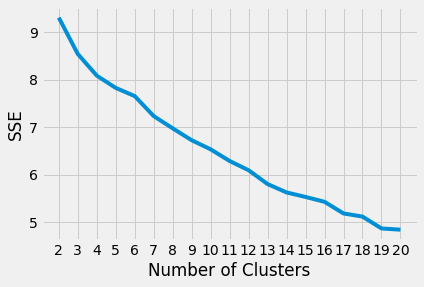

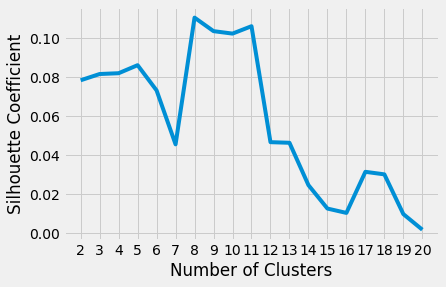

In [192]:
kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42 }
# A list holds the SSE values for each k
sse = []
silhouetteCoefs = []
ks = range(2, 21)
for k in ks:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(venuesGroupedClustering)
    sse.append(kmeans.inertia_)
    score = silhouette_score(venuesGroupedClustering, kmeans.labels_)
    silhouetteCoefs.append(score)

plotKMeansErrors(sse, silhouetteCoefs, ks)

In [186]:
# set number of clusters
kclusters = 8
venuesGroupedClustering = venuesGrouped.drop("Neighbourhood", 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(venuesGroupedClustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([7, 3, 1, 7, 7, 0, 7, 0, 1, 5])

In [194]:
# add clustering labels
neighVenuesSorted.insert(loc=0, column="Cluster Labels", value=kmeans.labels_)
mergedDF = newDF
# merge with original neighbourhood data
mergedDF = mergedDF.join(neighVenuesSorted.set_index("Neighbourhood"), on="Neighbourhood", how="inner")
mergedDF.head()

,Neighbourhood,Pincode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"A F Station Yelahanka,BSF Campus Yelahanka",560063,13.129087,77.614226,17,Indian Restaurant,Hot Spring,Lake,Department Store,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Museum
1,Adugodi,560030,12.944150,77.607623,6,Café,Spa,Tea Room,Kerala Restaurant,Nightclub,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Mughlai Restaurant
2,"Agara,Koramangala I Block,Koramangala,St. John...",560034,12.926138,77.622109,9,Indian Restaurant,Café,Pub,Coffee Shop,Ice Cream Shop,Kerala Restaurant,Bakery,Restaurant,Fast Food Restaurant,Brewery
3,Agram,560007,12.957917,77.630912,9,Pizza Place,Historic Site,Indian Restaurant,Golf Course,Nightclub,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Mughlai Restaurant
4,"Amruthahalli,Byatarayanapura,Kodigehalli,Sahak...",560092,13.064104,77.593121,11,Indian Restaurant,Ice Cream Shop,Bus Station,Resort,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Bubble Tea Shop,Flea Market,Garden


In [195]:
createFoliumMap(
    locLat=bangaloreCoords["Latitude"], 
    locLng=bangaloreCoords["Longitude"], 
    markerLats=mergedDF["Latitude"], 
    markerLngs=mergedDF["Longitude"], 
    markerColors=mergedDF["Cluster Labels"], 
    markerLabels=mergedDF["Neighbourhood"], 
    zoomStart=11, showScale=True, showCenter=True
)

## 4. Methodology <a name="method"></a>

In [174]:
categories = allVenues["Category"].unique()
categories.sort()
print(categories)

['ATM' 'Accessories Store' 'Afghan Restaurant' 'Airport' 'Airport Service'
 'Airport Terminal' 'American Restaurant' 'Andhra Restaurant' 'Arcade'
 'Art Gallery' 'Arts & Crafts Store' 'Asian Restaurant'
 'Athletics & Sports' 'Auto Garage' 'Automotive Shop' 'BBQ Joint'
 'Badminton Court' 'Bagel Shop' 'Bakery' 'Bar' 'Basketball Court'
 'Bed & Breakfast' 'Beer Bar' 'Bengali Restaurant' 'Big Box Store'
 'Bike Shop' 'Bistro' 'Boarding House' 'Boat or Ferry' 'Bookstore'
 'Botanical Garden' 'Boutique' 'Bowling Alley' 'Boxing Gym'
 'Breakfast Spot' 'Brewery' 'Bridge' 'Bubble Tea Shop' 'Building'
 'Burger Joint' 'Burrito Place' 'Bus Line' 'Bus Station' 'Bus Stop'
 'Business Service' 'Butcher' 'Cafeteria' 'Café' 'Camera Store'
 'Candy Store' 'Cantonese Restaurant' 'Capitol Building'
 'Caribbean Restaurant' 'Chaat Place' 'Chettinad Restaurant'
 'Chinese Restaurant' 'Chocolate Shop' 'Clothing Store' 'Cocktail Bar'
 'Coffee Shop' 'Concert Hall' 'Convenience Store' 'Cosmetics Shop'
 'Coworking Space'